# **1. Basics**
**Prerequisites**

`pytorch`, `torchvision`, `numpy`, `openCV2`,`matplotlib`

In [3]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# For utilities
import time, sys, os
sys.path.insert(0, '../../')

# For conversion

import cv2
import opencv_transforms.transforms as TF
import opencv_transforms.functional as FF
import dataloader

# For everything
import torch
import torch.nn as nn
import torchvision.utils as vutils
from torch.autograd import Variable

# For our model
import mymodels
import torchvision.models
import itertools

# To ignore warning
import warnings
warnings.simplefilter("ignore", UserWarning)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device=='cuda':
    print("The gpu to be used : {}".format(torch.cuda.get_device_name(0)))
else:
    print("No gpu detected")

The gpu to be used : GeForce GTX 1060 6GB


# **1. Loading dataset**

## 1.1 Load dataset

To pre-process input images, the module `opencv_transforms.transforms` and `opencv_transforms.functional` are used. [1] These are implemented with **openCV** so much faster than `torchvision.transforms` which is based on **Pillow**. 

To download dataset, go [2] and download. Unzip the images on directory `./dataset/'.

[1] Jim Bohnslav,"opencv_transforms", https://github.com/jbohnslav/opencv_transforms, 2020.1.13.

[2] https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/

In [4]:
# batch_size
batch_size = 1

# Training data
print('Loading Training data...', end=' ')
train_transforms = TF.Compose([
    TF.Resize(256),
    TF.RandomHorizontalFlip(),
    ])

train_imagefolder = dataloader.PairImageFolder('./dataset/yosemite',
                                              train_transforms,
                                              mode='train')
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=batch_size, shuffle=True)
print("Done!")
print("Training data size : {}".format(len(train_imagefolder)))
train_batch = next(iter(train_loader))

Loading Training data... Done!
Training data size : 962


## 1.2 Dataset Test

Check the dataset.

In [5]:
temp_batch_iter = iter(train_loader)

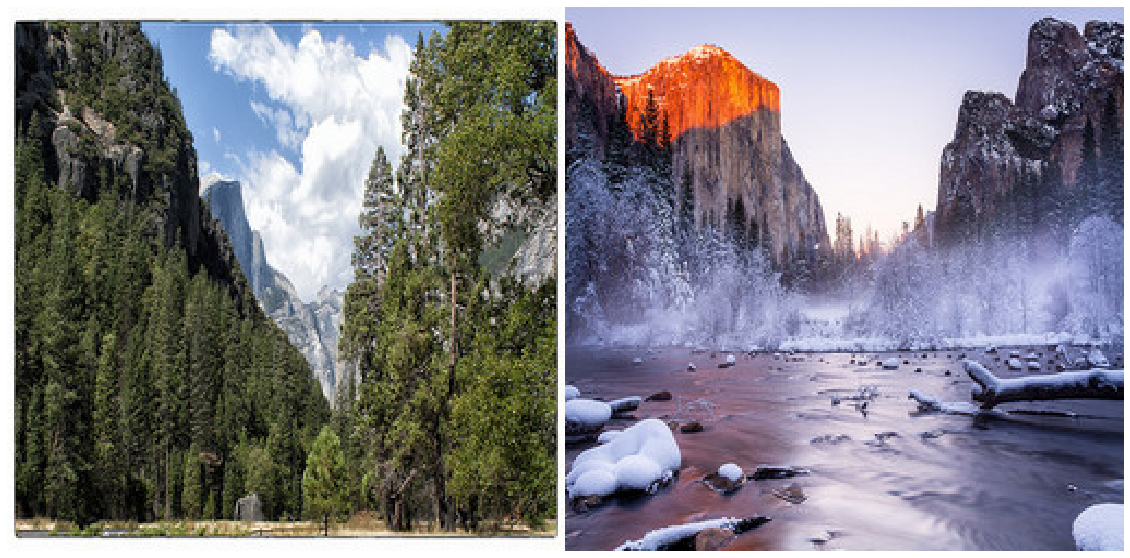

In [6]:
temp_batch = next(temp_batch_iter)
imgA = temp_batch[0]
imgB = temp_batch[1]

dataloader.show_example([imgA, imgB], (20,10))

# **2. Construct the Model**

All models are implemented on `mymodels.py`.

In [7]:
# A : Edge, B : Color
num_att = 5
netG_A2B = mymodels.Generator(input_nc=3, 
                              output_nc=3, 
                              num_att=num_att, 
                              ngf=64, 
                              n_middle=9, 
                              norm='IN', 
                              activation='relu',
                              pretrained=False).to(device)
netG_B2A = mymodels.Generator(input_nc=3, 
                              output_nc=3, 
                              num_att=num_att, 
                              ngf=64, 
                              n_middle=9, 
                              norm='IN', 
                              activation='relu',
                              pretrained=False).to(device)
netD_A = mymodels.Discriminator(input_nc=3, 
                                norm='IN', 
                                activation='lrelu', 
                                pretrained=False).to(device)
netD_B = mymodels.Discriminator(input_nc=3, 
                                norm='IN', 
                                activation='lrelu', 
                                pretrained=False).to(device)

num_params = sum(p.numel() for p in netG_A2B.parameters() if p.requires_grad) + sum(p.numel() for p in netD_A.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params*2))

torch.backends.cudnn.benchmark = True
print(netG_A2B)
print(netD_A)

Number of parameters: 17940352
Generator(
  (encoder): Encoder(
    (layer1): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): Identity()
      (activation): ReLU(inplace=True)
    )
    (layer2): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): ReLU(inplace=True)
    )
    (layer3): ConvBlock(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): ReLU(inplace=True)
    )
  )
  (middle): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_ru

# **3. Train the Model**

## 3.1 Set hyperparameters, optimizer, loss, etc.

There are four loss fucntions which are

(1) Adversarial Loss (WGAN-gp)

(2) L1 distance between real and reconstructed image (Cycle consistancy)

(3) Identity loss

In [8]:
def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(real_data.size(0), 1, 1, 1).to(device)
    x_interpolate = ((1 - alpha) * real_data + alpha * fake_data).detach()

    x_interpolate.requires_grad = True
    d_inter_logit = netD(x_interpolate)
    grad = torch.autograd.grad(d_inter_logit, 
                               x_interpolate,
                               grad_outputs=torch.ones_like(d_inter_logit), 
                               create_graph=True)[0]
    norm = (grad.view(grad.size(0), -1)).norm(p=2, dim=1)

    d_gp = ((norm - 1) ** 2).mean()
    
    return d_gp

In [9]:
# epoch_num
current_epoch=0
epoch_num = 50
# learning rate
lr = 2e-4
# Loss functions
criterion_L1 = torch.nn.L1Loss() # L1 Loss
# Gamma
gamma = 10
# Lambda
lambda1 = 100
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
beta2 = 0.999
critic_iter = 1

In [10]:
# Setup Adam optimizers for both G and D
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()), lr=lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(itertools.chain(netD_A.parameters(), netD_B.parameters()), lr=lr, betas=(beta1, beta2))

In [11]:
def save(path, netG_A2B, netG_B2A, netD_A, netD_B, optimizer_G, optimizer_D, epoch):
    print('Saving...', end=' ')
    state = {
        'epoch': current_epoch,
        'netG_A2B': netG_A2B.state_dict(),
        'netG_B2A': netG_B2A.state_dict(),        
        'netD_A': netD_A.state_dict(),
        'netD_B': netD_B.state_dict(),        
        'optimizer_G': optimizer_G.state_dict(),
        'optimizer_D': optimizer_D.state_dict(),
        }
    torch.save(state, './checkpoint/'+path)
    print("Done!")

## 3.2 Train the model


In [12]:
# Lists to keep track of progress
loss_list_D = []
loss_list_G = []
w_list = []

In [1]:
# Training Loop
print("Starting Training Loop...")
# For each epoch
start_epoch = current_epoch
last_epoch = epoch_num + current_epoch - 1
for epoch in range(current_epoch, epoch_num + current_epoch):
    current_epoch += 1
       
    start_time = time.time()
    total_time = 0
    running_w_list = []
    
    print('Epoch [{0}/{1}]'.format(epoch, last_epoch))
    for i, data in enumerate(train_loader, 0):                  
            
        # Set model input
        imgA = data[0].to(device)
        imgB = data[1].to(device)

        b_size = imgA.size(0)

        ###### Discriminator ######
        netD_A.zero_grad()
        netD_B.zero_grad()
        
        # Outputs
        fakeA, _, attB = netG_B2A(imgB)
        fakeB, _, attA = netG_A2B(imgA)

        # GAN loss
        pred_fake = netD_A(fakeA.detach()) + netD_B(fakeB.detach())
        pred_real = netD_A(imgA) + netD_B(imgB)
        loss_D_GAN = pred_fake.mean() - pred_real.mean()
        
        gp = calc_gradient_penalty(netD_A, imgA, fakeA) + calc_gradient_penalty(netD_B, imgB, fakeB)
        
        # Total loss
        loss_D = loss_D_GAN + gamma*gp

        # Update
        loss_D.backward()
        optimizer_D.step()
        running_w_list.append(-loss_D_GAN.item())
        
        ###################################
        
        if i % critic_iter == 0:
            ###### Generators ######
            netG_A2B.zero_grad()
            netG_B2A.zero_grad()

            # Outputs
            #fakeA, _, attB = netG_B2A(imgB)
            #fakeB, _, attA = netG_A2B(imgA)
            idtA, _, _ = netG_B2A(imgA)
            idtB, _, _ = netG_A2B(imgB)
            recA, _, _ = netG_B2A(fakeB)
            recB, _, _ = netG_A2B(fakeA)

            # GAN loss
            pred_fake = netD_A(fakeA) + netD_B(fakeB)
            loss_G_GAN = -pred_fake.mean()

            # Reconstruction loss
            loss_rec = criterion_L1(imgA, recA) + criterion_L1(imgB, recB)
            
            # Identity Loss
            loss_idt = criterion_L1(imgA, idtA) + criterion_L1(imgB, idtB)
            
            # Total loss
            loss_G = loss_G_GAN + 100 * loss_rec + loss_idt

            # Update
            loss_G.backward()
            optimizer_G.step()

            ###################################

        # Time Info.
        end_time = time.time()
        taken_time = end_time - start_time
        total_time += taken_time
        average_time = total_time / (i+1)

        # Wasserstein Distance
        w_avg = sum(running_w_list) / len(running_w_list)

        # Output training stats
        print('\r[%d/%d] Loss D_GAN: %.2f (%.2f) / GP: %.2f / Loss_G_GAN: %.2f / Loss_Rec: %.2f / Loss_Idt: %.2f / Time : %.2f (%.2f)'
              % (i+1, len(train_loader), loss_D_GAN.item(), w_avg,
                gp.item(), loss_G_GAN.item(), loss_rec.item(), loss_idt.item(), taken_time, average_time), end='     ')
        start_time = end_time
            
        if i % 1000 == 0:
            with torch.no_grad():
                dataloader.show_example([imgA, fakeB.detach(), recA.detach()], (30, 10)) 
                dataloader.show_example(attA, (50, 10))
                dataloader.show_example([imgB, fakeA.detach(), recB.detach()], (30, 10)) 
                dataloader.show_example(attB, (50, 10))            
                print()
                save('summer2winter/ckpt.pth', netG_A2B, netG_B2A, netD_A, netD_B, optimizer_G, optimizer_D, current_epoch)
    
                         
    # Record loss
    loss_list_D.append(loss_D.cpu().item())
    loss_list_G.append(loss_G.cpu().item())
    w_list.append(w_avg)
        
    print()

print('Done')

Starting Training Loop...


NameError: name 'current_epoch' is not defined

# **4. Save / Load the model**

## 4.1 Save the model

Save checkpoint


In [14]:
print("Current epoch : {}".format(current_epoch))
save('summer2winter/ckpt.pth', netG, netD, current_epoch)

Current epoch : 4
Saving... Done!


## 4.2 Load the model
Load checkpoint
To load the model weights, download the checkpoint on https://drive.google.com/open?id=1pIZCjubtyOUr7AXtGQMvzcbKczJ9CtQG (449MB) and unzip.

In [2]:
def load(netG_A2B, netG_B2A, netD_A, netD_B, optimizer_G, optimizer_D):
    print('Loading...', end=' ')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/summer2winter/ckpt.pth')
    netG_A2B.load_state_dict(checkpoint['netG_A2B'], strict=True)
    netG_B2A.load_state_dict(checkpoint['netG_B2A'], strict=True)
    netD_A.load_state_dict(checkpoint['netD_A'], strict=True)
    netD_B.load_state_dict(checkpoint['netD_B'], strict=True)
    optimizer_G.load_state_dict(checkpoint['optimizer_G']),
    optimizer_D.load_state_dict(checkpoint['optimizer_D']),
    print("Done!")

In [11]:
load(netG, netD)

Loading... Done!
